In [127]:
import os
import sys
import numpy as np

import matplotlib.pyplot as plt


sys.path.append("..")

Observations:
1. our model correctly learned the structure of text messages; it starts with a time stamp, followed by the sender's name, and then the message. E.g. '[12/12/2018, 12:34:56] Sender: Message'
2. Very nicely, the time stamp of generated messages is increasing, as long as the message is short enough to fit into the sequence length.

Hypotheses:
1. Each time stamp strongly attends to the previous time stamp. 
2. In deep layers, there is a feature that captures the sequential nature of the time stamps. 

### Generated text demonstrating our observations:
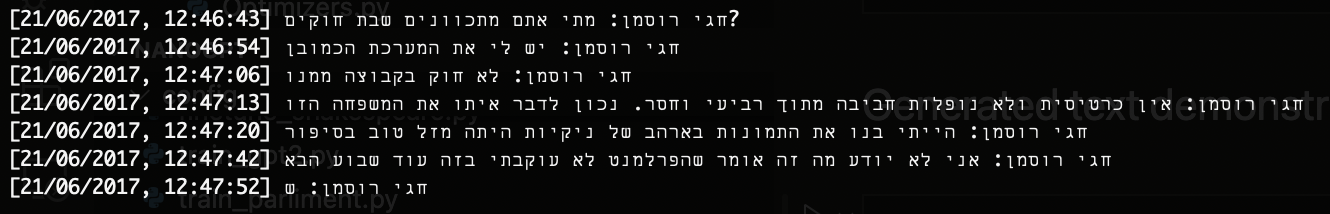

### Length of messages:

For this to be reasonable, we should see that the models saw short enough messages to fit into the sequence length of 256.
We are going to be lazy and just count the number of characters between each '\n', which is the length of the message, up to cases where the message itself contains a line break, but we will assume this is rare. 

We show below that this is not a crazy assumption.

In [128]:
with open('../data/parliment/input.txt', 'r') as f:
    full_chat = f.read()

full_chat[1000:1200]

'ה הוא מסתובב עם זה כל היום בכיס....\n[04/03/2013, 5:03:27] רועי מיארה: יש למישהו מטען לגלקסי...?\n[04/03/2013, 5:03:32] רועי מיארה: 💪\n[04/03/2013, 5:03:56] פיץ: כן\n[04/03/2013, 5:04:06] חגי בנשושן: לי י'

In [3]:
# sample 300 lines from the end of the chat
full_chat.split('\n')[-300:]

['אתה בוחר על מה ללחוץ או לא, וברור לך שיש פרסומות, אתה לרוב לא לוחץ עליהן',
 '[27/09/2023, 13:11:02] רועי מיארה: שאתה הולך לצאטגפטו אתה מחפש את המידע עצמו',
 '[27/09/2023, 13:11:13] רועי מיארה: אין בחירה',
 '[27/09/2023, 13:11:25] רועי מיארה: אתה לא יכול להציג מידע אחר של מפרסם',
 '[27/09/2023, 13:11:46] רועי מיארה: אולי, בינג יעשו מזה כסף',
 '[27/09/2023, 13:12:09] ערן !!: הי שלום, אני נוסע שבוע הבא לצרפת וצריך לנסוע מליל לפריז, מה הדרך הכי טובה לעשות את זה?',
 '',
 'גפט: יש מספר דרכים...אתה יכול לקחת רכבת מ.... בלה בלה בלה. אגב, תרצה שאעזור לך להזמין רכב?',
 '',
 '',
 '****גובה מחברת השכרת הרכב כסף***',
 '[27/09/2023, 13:12:31] רועי מיארה: זה כבר לא פרסומת אבל נכון? זה שירות',
 '[27/09/2023, 13:12:46] רועי מיארה: הבדל גדול',
 '[27/09/2023, 13:12:59] ערן !!: לא, זה פרסומת. אני לא ביקשתי להזמין רכב. חברת ההשכרה משלמת לאופואייאיי בכל פעם שהיא מציגה אופציה שקשורה אליה',
 '[27/09/2023, 13:13:02] ערן !!: זה פרסומת',
 '[27/09/2023, 13:13:08] רועי מיארה: גוגל עושה המון כסף כי אנשים משלמים ל

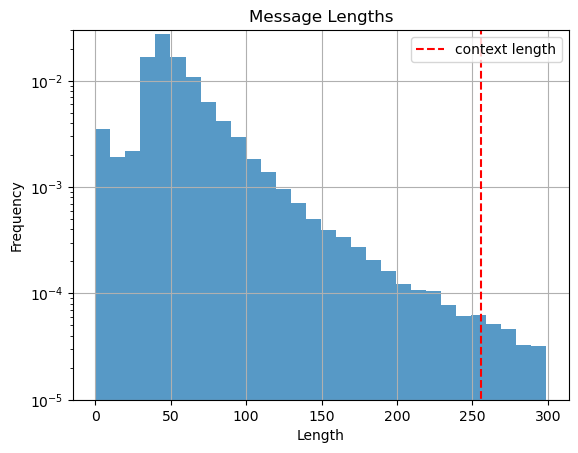

In [4]:
# Messeges length histogram
lengths = np.array([len(x) for x in full_chat.split('\n')])


# Plot
hist=plt.hist(lengths[lengths<300], bins=30, alpha=0.75, density=True)
plt.title('Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.vlines(256, 0, 0.2, colors='r', linestyles='dashed', label='context length')
plt.legend()
plt.ylim(1e-5, 0.03)
plt.yscale('log')
plt.show()



We see that indeed most messages are quite shorter than sequence length, along the model to actually attend to previous time stamps.

## Load and analyze the model

In [2]:
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

torch.set_grad_enabled(False) # make sure to not compute gradients, we are only doing inference




device = 'cuda' if torch.cuda.is_available() else 'cpu' # 'cpu' or 'cuda'
seed = 1337234
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster


torch.manual_seed(seed)
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
if device_type == 'cuda':
    torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() #if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)



# Load the GPT model
checkpoint = torch.load('../parliment_out/ckpt.pt', map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)
# Iterate over each attention layer in the model
for i, block in enumerate(model.transformer.h):
    attn = block.attn
    if not hasattr(attn, 'bias') or attn.bias is None:
        print(f"Initializing missing 'bias' in layer {i}")
        # Initialize the bias
        block_size = config.block_size
        attn.register_buffer("bias", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))


model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)


# Load the dictionary
with open('../data/parliment/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

number of parameters: 11.08M
Number of trainable parameters: 11,176,704, grouped into:
26 decayed parameter tensors, with 11,171,712 parameters
13 non-decayed parameter tensors, with 4,992 parameters


### Generate some text:

In [6]:
# -----------------------------------------------------------------------------
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
# -----------------------------------------------------------------------------





start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

torch.manual_seed(seed)
# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')


[02/07/2020, 11:24:56] ערן !!: נאמר מפחידה מהערב
‎[02/07/2020, 11:25:05] ערן !!: ‎image omitted
[02/07/2020, 11:25:19] ערן !!: איך יכול להיות שאני הולך להתחיל לי שלושה באבל לא קבוצת עתידות לו את הערב. יש לו התייחסות ביום הזה אני לא עוד איש דוקות נאומיות, של מושג המקורים. לא מבין מאמין שרוצים לעשות מתחת להוסיף.
[02/07/2020, 11:25:46] ערן !!: ככה באור נחמד ואין חיפה באופן הדיווחים שלי. זה חלק מהמערכת האלה הזו רק (אף אחד לא ישמעתי מצריך לשיקול הכל).
[02/07/2020, 11:26:02] ערן !!: איפה אתה מתאים לפת
---------------


Look how nice the generated time stamps are ordered!

### Simple games:

Now, we pass the model a message, and a time stamp prefix, and see  what the logit is for the next character.

In [3]:
names= ['חגי בנשושן', 'רועי מיארה', 'פיץ', 'Nadav Joseph Outmezguine', 'שבתאי', 'אבידן', 'רון נחשון', 'ערן !!']

for j, name in enumerate(names):
    sample_text='[04/11/2023, 18:21:55] '+name+': Yesterday I woke up sucking a lemon.\n[04/11/2023, 18:'
    ids = encode(sample_text)
    x = torch.tensor([ids], dtype=torch.long).to(device)

    # Get logits and probabilities
    logits, _ = model(x)
    probs = torch.softmax(logits, dim=-1)

    # Get the top 10 most likely tokens after the sample text
    topk = torch.topk(probs, 3)
    topk_indices = topk.indices.cpu().numpy().flatten()
    topk_probs = topk.values.cpu().numpy().flatten()
    print(f'----Member: {name}----')
    for (i, p) in zip(topk_indices, topk_probs):
        print(f'next token: {itos[i]}, probability: {100*p:.2f}%')
    

----Member: חגי בנשושן----
next token: 2, probability: 92.24%
next token: 3, probability: 6.03%
next token: 4, probability: 1.17%
----Member: רועי מיארה----
next token: 2, probability: 93.96%
next token: 3, probability: 4.74%
next token: 4, probability: 0.88%
----Member: פיץ----
next token: 2, probability: 92.76%
next token: 3, probability: 5.64%
next token: 4, probability: 1.07%
----Member: Nadav Joseph Outmezguine----
next token: 2, probability: 91.26%
next token: 3, probability: 6.74%
next token: 4, probability: 1.35%
----Member: שבתאי----
next token: 2, probability: 91.22%
next token: 3, probability: 6.75%
next token: 4, probability: 1.36%
----Member: אבידן----
next token: 2, probability: 92.52%
next token: 3, probability: 5.81%
next token: 4, probability: 1.12%
----Member: רון נחשון----
next token: 2, probability: 92.54%
next token: 3, probability: 5.79%
next token: 4, probability: 1.12%
----Member: ערן !!----
next token: 2, probability: 92.84%
next token: 3, probability: 5.59%
ne

In [126]:
attention_weights_list = []

def attention_hook(module, input, output):
    # Check if the attention weights are stored and append them to the list
    if hasattr(module, 'att_amps'):
        attention_weights_list.append(module.att_amps)
    else:
        print("Attention weights not available.")


# attention layer
layer_index = 5


# Access the specific attention layer within the chosen block
block_to_hook = model.transformer.h[layer_index].attn

# Register the hook to this layer
hook = block_to_hook.register_forward_hook(attention_hook)


name = 'Nadav Joseph Outmezguine'
sample_text='[04/11/2023, 18:21:55] '+name+': I am 123 lemons.\n[04/11/2023, 18:'
ids = encode(sample_text)
x = torch.tensor([ids], dtype=torch.long).to(device)

# Get logits and probabilities
logits, _ = model(x)


head_index = 0  # Example: looking at the first head
# Get the attention weights for the latest forward pass, and for the chosen head
attention_matrix = attention_weights_list[-1][..., head_index, :, :]  # Shape should be (B, T, T)


Clearly layer ind 3 and head 0 are the ones that are most likely to relate to the time of preve messages.
head 4 for layer 3 is also quite likely to relate to the time of previous messages, but in a bit wider context. namely, it looks like it cares about minuts.

5,1 might care about the vicinity to a new multiple of 10 minutes, meaning, in our example, whether if the current time is 12:3x, whether the next one would be at 12:3y or 12:4y, is sensitive to whether x is 0 or 9. similarly 5,4

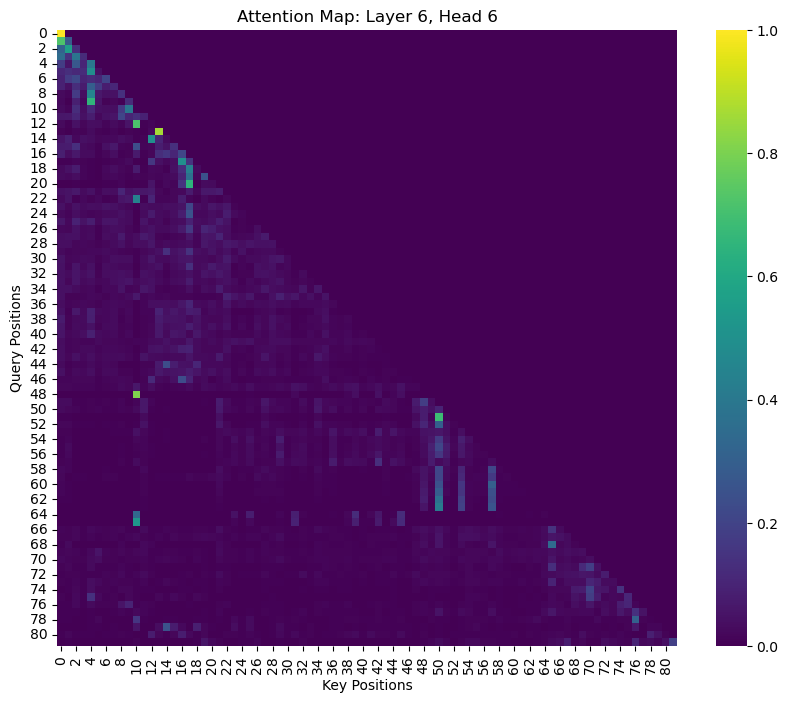

In [122]:
if attention_weights_list:
    head_index = 5  # Example: looking at the first head
    # Extract the attention weights for the specific head
    attention_matrix = attention_weights_list[-1][..., head_index, :, :]  # Shape should be (B, T, T)

    # Visualize the attention matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix[0].detach().cpu().numpy(), cmap='viridis')  # Visualizing the first in batch
    plt.title(f"Attention Map: Layer {layer_index + 1}, Head {head_index + 1}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()
else:
    print("No attention data captured.")


In [123]:
hook.remove()

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Normalize the attention scores
normalized_attention = attention_matrix[0].detach().cpu().numpy()
normalized_attention = (normalized_attention - np.min(normalized_attention)) / (np.max(normalized_attention) - np.min(normalized_attention))

def visualize_attention(text, attention):
    # Settings for the visual appearance of the table
    char_width = 16
    char_height = 18
    
    # Start the HTML for the table
    html_text = f'<table cellpadding="0" cellspacing="0" style="border-collapse: collapse; line-height: {char_height}px; margin: 0; padding: 0;">'
    
    # Generate the table with attention; each row shows up to the current character
    for i in range(len(text)):
        html_text += '<tr>'
        for j in range(len(text)):
            char = text[j]
            color_weight = attention[i][j]
            background_color = f'rgba(70, 130, 60, {color_weight})'
            
            # Highlight the current character with a border box and ensure the next characters are not shown
            if j == i:  # Current character
                html_text += f'<td style="background-color: {background_color}; color: black; width: {char_width}px; height: {char_height}px; font-size: 12px; font-family: monospace; border: 2px solid #000; text-align: center; padding: 0; margin: 0;">{char}</td>'
            elif j < i:  # Previous characters
                html_text += f'<td style="background-color: {background_color}; color: black; width: {char_width}px; height: {char_height}px; font-size: 12px; font-family: monospace; border: 1px solid #ddd; text-align: center; padding: 0; margin: 0;">{char}</td>'
            else:  # Following characters not shown
                html_text += f'<td style="background-color: rgba(70, 130, 80, 0); color: rgba(70, 130, 80, 0); width: {char_width}px; height: {char_height}px; font-size: 12px; font-family: monospace; border: 1px solid #ddd; text-align: center; padding: 0; margin: 0;"></td>'
        html_text += '</tr>'
    html_text += '</table>'
    
    
    # Display the HTML
    display(HTML(html_text))
# Visualize the entire matrix
visualize_attention(sample_text, normalized_attention)


[,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,/,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,/,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,/,2,0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,/,2,0,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[,0,4,/,1,1,/,2,0,2,3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


# New tokenizer, future work

In [131]:

new_token_dict = {'] Nadav Joseph Outmezguine: ': '丁', '] אבידן: ': '丂', '] רון נחשון: ': '七', '] ערן !!: ': '丄', '] חגי בנשושן: ': '丅', '] רועי מיארה: ': '丆', '] פיץ: ': '万', '] שבתאי: ': '丈', '] חגי רוסמן: ': '三'}
new_decoded = {v: k for k, v in new_token_dict.items()}

# make a copy of the input text and replace the names with the tokens
sample_text = full_chat
for k, v in new_token_dict.items():
    sample_text = sample_text.replace(k, v)

# crarte a toknized.txt file in the data folder
with open('../data/parliment/tokenized.txt', 'w') as f:
    f.write(sample_text)

len(set(sample_text))


1197

In [134]:
import tqdm
def find_unused_characters(text):
    used = set(text)
    unused = []
    for code in range(32, 0x110000):  # UTF-8 range from space to the edge of common planes
        if len(unused) >= 800:  # Stop if we've found enough unused characters
            break
        char = chr(code)
        if char not in used:
            unused.append(char)
    return unused

def replace_frequent_pairs(text, unused_chars):
    from collections import Counter, defaultdict
    
    # Function to get the frequency of pairs of adjacent characters
    def get_pair_frequency(text):
        pairs = Counter()
        for i in range(len(text) - 1):
            pair = text[i:i+2]
            if len(pair) == 2:
                pairs[pair] += 1
        return pairs

    # Dictionary to keep track of what each new character represents
    mapping = {}
    
    # Work on a copy of the text
    current_text = text
    
    # Replace pairs with unused characters
    for new_char in tqdm.tqdm(unused_chars):
        # Get the most frequent pair
        pair_freq = get_pair_frequency(current_text)
        if not pair_freq:
            break
        
        most_frequent_pair, freq = pair_freq.most_common(1)[0]
        
        # If the most frequent pair is not frequent enough, break
        if freq < 2:
            break
        
        # Replace all occurrences of this pair with the new unused character
        current_text = current_text.replace(most_frequent_pair, new_char)
        
        # Store what this new character represents
        mapping[new_char] = most_frequent_pair
    
    return current_text, mapping

# Example usage
unused_chars = find_unused_characters(sample_text)

# Replace pairs
new_text, mapping = replace_frequent_pairs(sample_text, unused_chars[:800])
# print("Original text:", text)
# print("Compressed text:", new_text)
# print("Mapping:", mapping)


  8%|▊         | 64/800 [03:20<38:22,  3.13s/it]


KeyboardInterrupt: 

In [143]:
import heapq
from collections import defaultdict, Counter
from tqdm import tqdm

class SillyTokenizer:
    def __init__(self, additional_tokens=800):
        self.additional_tokens = additional_tokens
        self.mapping = {}
        self.reverse_mapping = {}
        self.unused_chars = []

    def find_unused_characters(self, text):
        used = set(ord(c) for c in text)
        max_used = max(used) if used else 127
        candidate_start = max(32, max_used + 1)  # Start after the max used character

        self.unused_chars = []
        for code in range(candidate_start, min(candidate_start + 2000, 0x110000)):
            if len(self.unused_chars) >= self.additional_tokens:
                break
            if code not in used:
                self.unused_chars.append(chr(code))
        if len(self.unused_chars) < self.additional_tokens:
            # Look before 'max_used' if needed
            for code in range(32, candidate_start):
                if len(self.unused_chars) >= self.additional_tokens:
                    break
                if code not in used:
                    self.unused_chars.append(chr(code))

    def tokenize(self, text):
        self.find_unused_characters(text)
        current_text = list(text)
        
        char_index = 0
        used_new_chars = 0  # How many new characters have been used
        
        with tqdm(total=self.additional_tokens, desc="Tokenizing") as pbar:
            while used_new_chars < self.additional_tokens:
                # Initial pass to count pairs
                pair_freq = defaultdict(int)
                for i in range(len(current_text) - 1):
                    pair = (current_text[i], current_text[i+1])
                    pair_freq[pair] += 1
                
                if not pair_freq:
                    break
                
                # Get the most frequent pair
                most_frequent_pair, freq = max(pair_freq.items(), key=lambda x: x[1])
                
                if freq < 2:
                    break

                if char_index < len(self.unused_chars):
                    # Use the next unused character for this pair
                    new_char = self.unused_chars[char_index]
                    char_index += 1
                else:
                    break

                # Update mapping and reverse mapping
                most_frequent_pair_str = ''.join(most_frequent_pair)
                self.mapping[new_char] = most_frequent_pair_str
                self.reverse_mapping[most_frequent_pair_str] = new_char
                
                # Replace occurrences of the pair in the current text
                new_text = []
                skip_next = False
                for i in range(len(current_text) - 1):
                    if skip_next:
                        skip_next = False
                        continue
                    if current_text[i] == most_frequent_pair[0] and current_text[i+1] == most_frequent_pair[1]:
                        new_text.append(new_char)
                        skip_next = True
                    else:
                        new_text.append(current_text[i])
                if not skip_next:
                    new_text.append(current_text[-1])
                
                current_text = new_text
                used_new_chars += 1
                pbar.update(1)

        return ''.join(current_text)

    def detokenize(self, encoded_text):
        # Recursively expand each character in the encoded text
        def expand(text):
            result = []
            i = 0
            while i < len(text):
                if text[i] in self.mapping:
                    result.append(expand(self.mapping[text[i]]))
                else:
                    result.append(text[i])
                i += 1
            return ''.join(result)
        
        return expand(encoded_text)

# Example Usage
tokenizer = SillyTokenizer(additional_tokens=10)
text = "abababababcdef"
encoded_text = tokenizer.tokenize(text)
decoded_text = tokenizer.detokenize(encoded_text)

print("Original text:", text)
print("Encoded text:", encoded_text)
print("Decoded text:", decoded_text)
print("Mapping:", tokenizer.mapping)


Tokenizing:  20%|██        | 2/10 [00:00<00:00, 34663.67it/s]

Original text: abababababcdef
Encoded text: hhgcdef
Decoded text: abababababcdef
Mapping: {'g': 'ab', 'h': 'gg'}


In [145]:
tokenizer = SillyTokenizer(additional_tokens=800)
# text = "ababababababababababababababababababababababcdef"
encoded_text = tokenizer.tokenize(sample_text)
decoded_text = tokenizer.detokenize(encoded_text)

Tokenizing: 100%|██████████| 800/800 [34:19<00:00,  2.57s/it]


# Find weights etc.. Later

In [86]:
model.transformer.h[5].attn

CausalSelfAttention(
  (c_attn): Linear(in_features=384, out_features=1152, bias=False)
  (c_proj): Linear(in_features=384, out_features=384, bias=False)
  (attn_dropout): Dropout(p=0.3, inplace=False)
  (resid_dropout): Dropout(p=0.3, inplace=False)
)

In [89]:
checkpoint['model_args']['n_layer']

6

In [97]:
import math
attn = [[]]*checkpoint['model_args']['n_layer']

def head_hook(layer_idx):
    results = []
    attn[layer_idx] = results
    def get_attn_hook(model, input, output):
        x = input[0]
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = model.c_attn(x).split(model.n_embd, dim=2)
        k = k.view(B, T, model.n_head, C // model.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, model.n_head, C // model.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, model.n_head, C // model.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(model.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        results.append(att.detach().numpy())
    return get_attn_hook

for layer_idx in range(checkpoint['model_args']['n_layer']):
    model.transformer.h[layer_idx].attn.register_forward_hook(head_hook(layer_idx))


In [99]:
def remove_heads(model):
    for layer in model.transformer.h:
        layer.attn._forward_hooks = OrderedDict()
remove_heads(model)

In [106]:
decode([logits.argmax().item()])

'1'

In [100]:
sample_text='[04/11/2023, 18:14:27] '+names[0]+': אני לא פיראט, ילדתי, לא חובל.\n[04/11/2023, 18:'
ids = encode(sample_text)
x = torch.tensor([ids], dtype=torch.long).to(device)

from collections import defaultdict, OrderedDict


# Get logits and probabilities
logits, _ = model(x)

def remove_heads(model):
    for layer in model.transformer.h:
        layer.attn._forward_hooks = OrderedDict()
remove_heads(model)

def diag_word(word):
    word_list = []
    for i in range(len(word)):
        word_list.append(word[:i+1] + ' '*(len(word) - i - 1))
    return word_list

head_attn = np.squeeze(np.array(attn))
head_attn.shape # (layer, batch, block, block)

(6, 0)

In [64]:
wq.shape, wq.T.shape

(torch.Size([384, 384]), torch.Size([384, 384]))

True


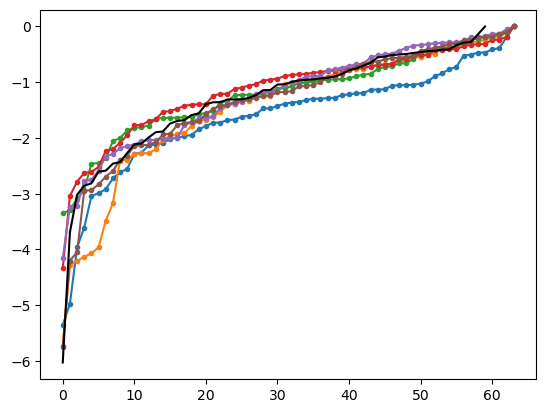

In [145]:
args=checkpoint['model_args']
c_attn=model.transformer.h[0].attn.c_attn
wq,wk,wv=c_attn.weight.split(args['n_embd'], dim=0)
wq=wq.T
wk=wk.T
wqh = wq.view(args['n_embd'], args['n_head'], args['n_embd'] // args['n_head']).transpose(0, 1)
wkh = wk.view(args['n_embd'], args['n_head'], args['n_embd'] // args['n_head']).transpose(0, 1)
    
# random input tensor
x = torch.randn(13,11, args['n_embd'])
q, k, v  = c_attn(x).split(args['n_embd'], dim=2)
print(torch.isclose(k, x @ wk).all().item())

k = k.view(13,11, args['n_head'], args['n_embd'] // args['n_head']).transpose(1, 2)
torch.isclose(k[:,0], x @ wkh[0]).all().item()



dot=torch.einsum('ijk,ijk->ik', wkh, wqh)
nor=torch.norm(wkh, dim=1)*torch.norm(wqh, dim=1)

A=torch.randn(60, args['n_embd'])
B=torch.randn(60, args['n_embd'])
ddot=torch.einsum('ij,ij->i', A, B)
ddot/=torch.norm(A, dim=1)*torch.norm(B, dim=1)
ddot=ddot.abs().log().sort().values.numpy()
ddot-=ddot[-1]

for t in (dot/nor).abs().log():
    temp=t.sort().values.numpy()
    temp-=temp[-1]
    plt.plot(temp,'.-')
plt.plot(ddot, 'k')
plt.show()


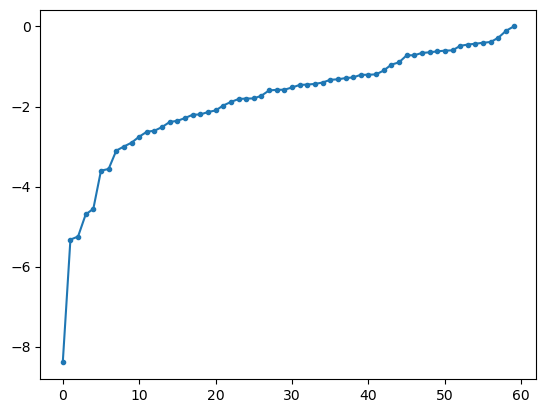

In [144]:
A=torch.randn(60, args['n_embd'])
B=torch.randn(60, args['n_embd'])
dot=torch.einsum('ij,ij->i', A, B)
dot/=torch.norm(A, dim=1)*torch.norm(B, dim=1)
dot=dot.abs().log().sort().values.numpy()
dot-=dot[-1]
plt.plot(dot,'.-')
plt.show()

We have two tensors that agree:
A = c_attn(x).split(args['n_embd'], dim=2)[0] 
B = x @ wq
A==B

Now, we define A

In [78]:
import numpy as np

# Original tensor with C=4
C = torch.tensor([0, 1, 2, 3])

C.view(2, 2)

tensor([[0, 1],
        [2, 3]])

In [27]:
torch.mul(wqh.norm(dim=1),wkh.norm(dim=1))

tensor([[0.0617, 0.0750, 0.0680, 0.0850, 0.0911, 0.0678, 0.0777, 0.0566, 0.0668,
         0.0763, 0.0722, 0.0708, 0.0711, 0.0716, 0.1068, 0.0948, 0.0581, 0.1188,
         0.0802, 0.0755, 0.1000, 0.0873, 0.0981, 0.0600, 0.0878, 0.0807, 0.0869,
         0.0634, 0.0724, 0.0945, 0.1089, 0.0677, 0.0968, 0.0677, 0.0832, 0.0911,
         0.0641, 0.0698, 0.0759, 0.0774, 0.0934, 0.0671, 0.0975, 0.0847, 0.0911,
         0.0642, 0.1187, 0.0754, 0.0766, 0.0768, 0.0896, 0.0679, 0.0704, 0.0738,
         0.0767, 0.0712, 0.0832, 0.1000, 0.0603, 0.1097, 0.0936, 0.1002, 0.0874,
         0.0662],
        [0.0604, 0.0626, 0.0672, 0.0662, 0.0736, 0.0679, 0.0696, 0.0479, 0.0562,
         0.0552, 0.0653, 0.0617, 0.0559, 0.0671, 0.0818, 0.0819, 0.0648, 0.0964,
         0.0658, 0.0518, 0.0753, 0.0729, 0.0920, 0.0589, 0.0691, 0.0699, 0.0839,
         0.0721, 0.0592, 0.0798, 0.1001, 0.0567, 0.0761, 0.0566, 0.0694, 0.0761,
         0.0626, 0.0710, 0.0628, 0.0672, 0.0783, 0.0556, 0.0696, 0.0663, 0.0682,
         0

In [14]:
wqs[0], wqh[0]

(tensor([[-0.0061,  0.0040,  0.0094,  ..., -0.0024,  0.0037, -0.0043],
         [-0.0319, -0.0124,  0.0149,  ..., -0.0134, -0.0112, -0.0170],
         [ 0.0003,  0.0372,  0.0122,  ..., -0.0308, -0.0118, -0.0031],
         ...,
         [-0.0123, -0.0189, -0.0241,  ...,  0.0143,  0.0047,  0.0091],
         [ 0.0107, -0.0050, -0.0066,  ...,  0.0269,  0.0118,  0.0114],
         [ 0.0326, -0.0012,  0.0083,  ..., -0.0044, -0.0110,  0.0127]],
        requires_grad=True),
 tensor([[-0.0061,  0.0040,  0.0094,  ..., -0.0024,  0.0037, -0.0043],
         [-0.0006,  0.0088,  0.0041,  ..., -0.0015,  0.0119,  0.0373],
         [-0.0190, -0.0438,  0.0086,  ...,  0.0187, -0.0087,  0.0400],
         ...,
         [ 0.0082,  0.0124, -0.0233,  ...,  0.0035,  0.0189,  0.0128],
         [-0.0060,  0.0245,  0.0318,  ..., -0.0095, -0.0082,  0.0289],
         [-0.0061,  0.0145,  0.0236,  ..., -0.0210, -0.0270, -0.0216]],
        requires_grad=True))

In [52]:
R=torch.randn(12,12)
torch.einsum('ij -> i',R)

TypeError: einsum() got an unexpected keyword argument 'keepdim'